---
# Utility (Analysis)

In [8]:
# Wordcloud Utilities
wc_stopwords=set(STOPWORDS)
def generate_wordcloud_image(words):
    """Generate world could image"""
    image = WordCloud(
        max_words=500, 
        min_font_size=5,
        width = 1000, 
        height = 500,
        stopwords=wc_stopwords, 
        background_color="black", 
        margin=5, 
        collocations=False,
        random_state=10
    ).generate(words)
    return image

def generate_healthy_comment_wordclouds():
    words_healthy = " ".join(train[train['unhealthiness'] == 0]["comment_text"].values)
    plt.figure(figsize=(12, 10))
    plt.title("Frequent words in Healthy comments", fontsize=25)
    plt.axis("off")
    plt.imshow(generate_wordcloud_image(words_healthy), interpolation = 'bilinear')
    del words_healthy
    
def generate_unhealthy_comment_wordclouds():
    num_cols = 2
    num_rows = len(CATEGORIES) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,15))
    plt.axis('off')
    images = []
    for index, category in enumerate(CATEGORIES):
        image = generate_wordcloud_image(
            " ".join(train[train[category] == 1]["comment_text"].values)
        )
        images.append(image)

    for index, category in enumerate(CATEGORIES):
        row = index // num_cols
        col = index % num_cols
        ax = axes[row][col]
        ax.imshow(images[index])
        ax.set_title(
            category, 
            fontdict={'fontsize': 25, 'fontweight': 'medium'}
        )
        for pos in ['top', 'bottom', 'right', 'left']:
            ax.spines[pos].set_visible(False)
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticklabels([])
            ax.set_yticks([])

    fig.tight_layout()
    plt.show()
    del images
    del fig, axes

import collections
class WordAnalysis:
    def __init__(self, corpus):
        """Generate word indices from a text corpus
        Args:
            corpus: A string including sentences to process.
        """
        words = corpus.lower().split()
        self._total = len(words)
        assert self._total > 0

        self._counts = collections.Counter(words)
        del words
        self._word_to_probability = {
            word: (count / self._total) for (word, count) in self._counts.items()
        }

        # --------------------------------------------------------------------------------
        # Vocabulary from the keys of probabilities preserving the same word order
        # --------------------------------------------------------------------------------
        self.vocabulary = list(self._word_to_probability.keys())

    def probability(self, word):
        return self._word_to_probability.get(word.lower(), 0.0)

    def count(self, word):
        """Number of times when the word occured in the original corpus"""
        return self._counts.get(word.lower(), 0)

    def size(self):
        """Number of words in the vocabulary"""
        return len(self.vocabulary)

    def total(self):
        """Total words in the original corpus"""
        return self._total

    def top(self, n):
        """Top n most common words"""
        assert 0 < n < self._total
        return [
            (word, count/self._total)
            for (word, count) in self._counts.most_common(n)
        ]

In [9]:
def unhealthy_volume_ration_per_length():
    """Ratio of unhealthy comments in the length ranges"""
    ratios = []
    lengths = []
    max_length = 1000
    interval = 50
    steps = range(0, max_length + 1, interval)
    for start in steps:
        stop = start + interval
        total_volume = train[
            (start <= train['length']) & (train['length'] < stop)
        ]['id'].count()
        unhealthy_volume = train[
            (start <= train['length']) & 
            (train['length'] < stop) & 
            (train['unhealthiness'] > 0)
        ]['id'].count()

        lengths.append(stop)
        ratios.append(unhealthy_volume / total_volume)

    return lengths, ratios

def run_analysis():
    """Run analysis on comment length significances"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10)) 
    bins = range(0, 1200+1, 100)
    limits=[0, 1200, 0, 40000]
    H = train[train['unhealthiness'] == 0]['length']
    U = train[train['unhealthiness'] > 0]['length']

    # --------------------------------------------------------------------------------
    # Volume / Length
    # Co-relation from length to the comment volume per healthy/unhealthy per ranges.
    # --------------------------------------------------------------------------------
    # Volume per Length
    ax_volume_length = axes[0][0]
    hist_on_ax(ax_volume_length, bins, U, label="unhealthy comment", color='r', alpha=0.9, title="Comment volume per length", xlabel='Length of comments', ylabel='Number of comments', legend=True, limits=limits)
    hist_on_ax(ax_volume_length, bins, H, label="healthy comment", color='g', alpha=0.4, title="Comment volume per length", xlabel='Length of comments', ylabel='Number of comments', legend=True, limits=limits)
    ax_volume_length.plot([200, 200], [0, 35000], linestyle='--', linewidth=2, color='r', alpha=0.5)

    # --------------------------------------------------------------------------------
    # Ratio / Length
    # Co-relation from length to unhealthy volume ratio against total volume IN the ranges.
    # This is not a cumulative volume but the volume within each specific range e.g. 
    # comment length between 100 and 200.
    # --------------------------------------------------------------------------------
    ax_ratio_length = axes[0][1]
    X, Y = unhealthy_volume_ration_per_length()
    plot_on_ax(ax_ratio_length, X, Y, label="unhealthy ratio", color='orange', title="Unhealthy comment ratio", xlabel='Length of comments', ylabel='Ratio of unhealthy comments', legend=True, limits=None)
    ax_ratio_length.plot([200, 200], [0.01, 0.17], linestyle='--', linewidth=2, color='r', alpha=0.5)

    # --------------------------------------------------------------------------------
    # Length / Percentile
    # Co-relation from percentile (total accumulative volume) to unhealthy comment length 
    # --------------------------------------------------------------------------------
    quantiles = np.linspace(.1, 1, 9, 0)
    ax_legth_percentile = axes[1][0]
    comment_length_percentil_U = U = (train[train['unhealthiness'] > 0]['length']).quantile(np.linspace(.1, 1, 9, 0), 'lower').values
    comment_length_percentil_H = H = (train[train['unhealthiness'] == 0]['length']).quantile(np.linspace(.1, 1, 9, 0), 'lower').values
    plotter(ax_legth_percentile, quantiles, H, U, 'g', 'r', "Healthy", "Unhealthy", 'Percentil', 'Comment length', "Comment length percentile", [None, None, 0, 1000], False)
    ax_legth_percentile.plot([0.05, 0.95], [200, 200], linestyle='--', linewidth=2, color='r', alpha=0.5)

    # Ratio / Percentile
    ax_ratio_percentile = axes[1][1]
    ratio = comment_length_percentil_U / comment_length_percentil_H
    plotter(ax_ratio_percentile, quantiles, ratio, None, 'k', 'r', "length ratio (unhealthy/healthy)", None, 'Percentil', 'Ratio', "Comment length Ratio", [None, None, 0, 1], True)


healthy = train[train['unhealthiness'] == 0]
unhealthy = train[train['unhealthiness'] > 0]

# --------------------------------------------------------------------------------
# Unhealthy volume ratio
# --------------------------------------------------------------------------------
start = 0
stop = 200
total_volume = train[
    (start <= train['length']) & (train['length'] < stop)
]['id'].count()
unhealthy_volume = train[
    (start <= train['length']) & 
    (train['length'] < stop) & 
    (train['unhealthiness'] > 0)
]['id'].count()
print(f"\n{SEP}Unhealthy volume ratio (<{stop}:\n{SEP}{unhealthy_volume/total_volume}\n")

# --------------------------------------------------------------------------------
# Comment length histram (bins = [1,200,400,600,800,1000,1200])
# --------------------------------------------------------------------------------
sep = ("".join((["-"] * 80))) + "\n"
print(
    f"{SEP}Histgram for Healthy comment length:\n{SEP}"
    f"{healthy.groupby(pd.cut(healthy['length'], np.arange(0, 1200, 200)))['id'].count()}"
)
print(
    f"\n{SEP}Histgram for Unhealthy comment length:\n{SEP}"
    f"{unhealthy.groupby(pd.cut(unhealthy['length'], np.arange(0, 1200, 200)))['id'].count()}"
)

# --------------------------------------------------------------------------------
# Quantiles of comment length
# --------------------------------------------------------------------------------
print(f"{SEP}Quantiles of comment length (healthy)\n{SEP[:-1]}")
print(healthy['length'].quantile(np.linspace(.1, 1, 9, 0)))

print(f"\n{SEP}Quantiles of comment length (unhealthy)\n{SEP[:-1]}")
print(unhealthy['length'].quantile(np.linspace(.1, 1, 9, 0)))

# --------------------------------------------------------------------------------
# Median comment length
# --------------------------------------------------------------------------------
print(f"{SEP}Median comment length:\n{SEP}Healthy[{healthy['length'].median()}] \nUnhealthy[{unhealthy['length'].median()}]")

NameError: ignored

# Analysis

### Dominant words

### Objective

Overviews on the dominant words for healthy comments, and each type of healhthy comments.

### Healthy comment

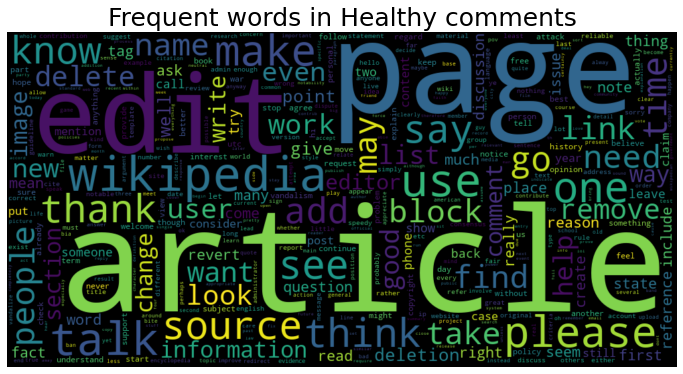

In [ ]:
generate_healthy_comment_wordclouds()

### Unhealthy  Comment

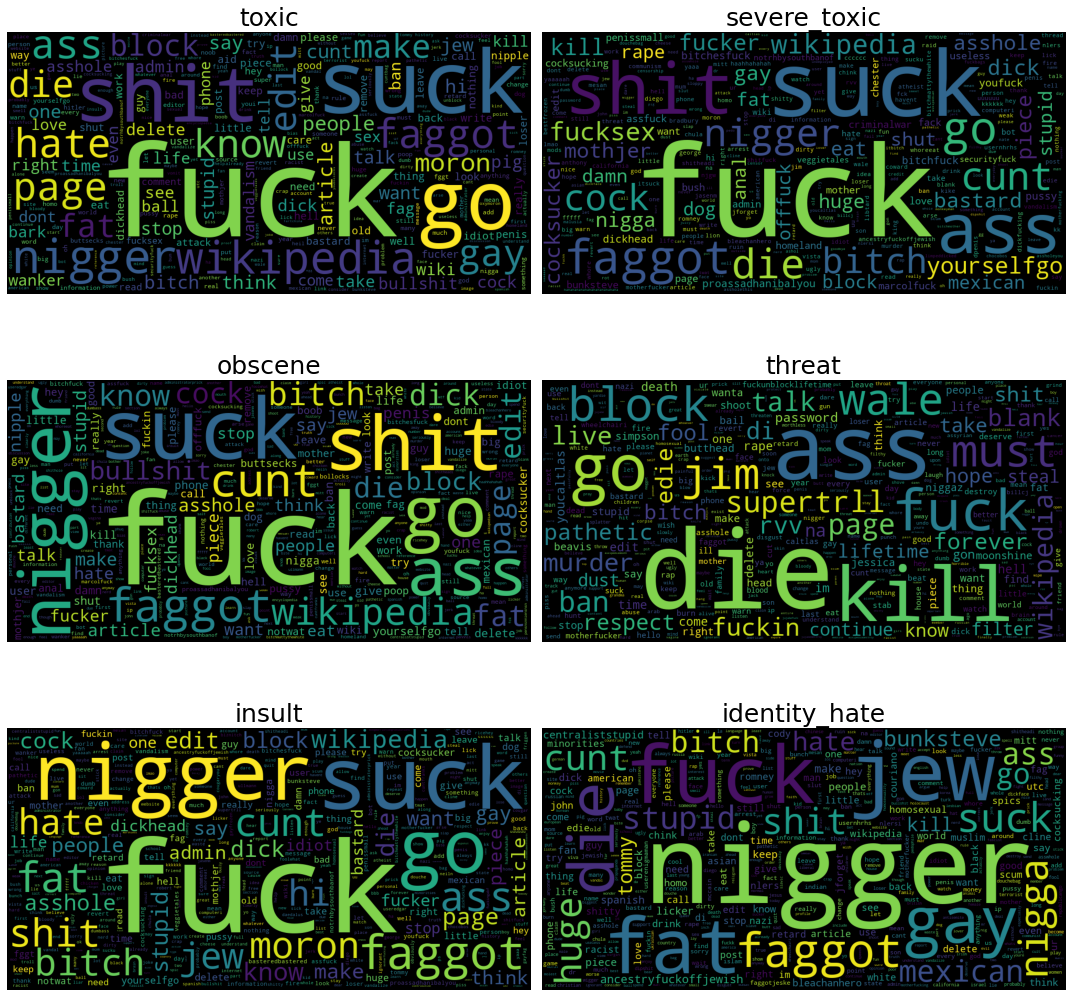

In [ ]:
generate_unhealthy_comment_wordclouds()

## Comment length

### Objective
**Co-relation** between the **length** and **healthiness** of a comment. *Healthiness* is a binary classification either a comment is healthy or unhealthy where "unhealthy" comments are those labeled as toxic, insult, etc.

### Findings

> * ***Unhealthy*** comments tend to be **short**. 
> * Approx 13.5% of total comments shorter than **200** are unhealthy.
> * Approx 65% of unhealthy comments are shorter than **200**. 


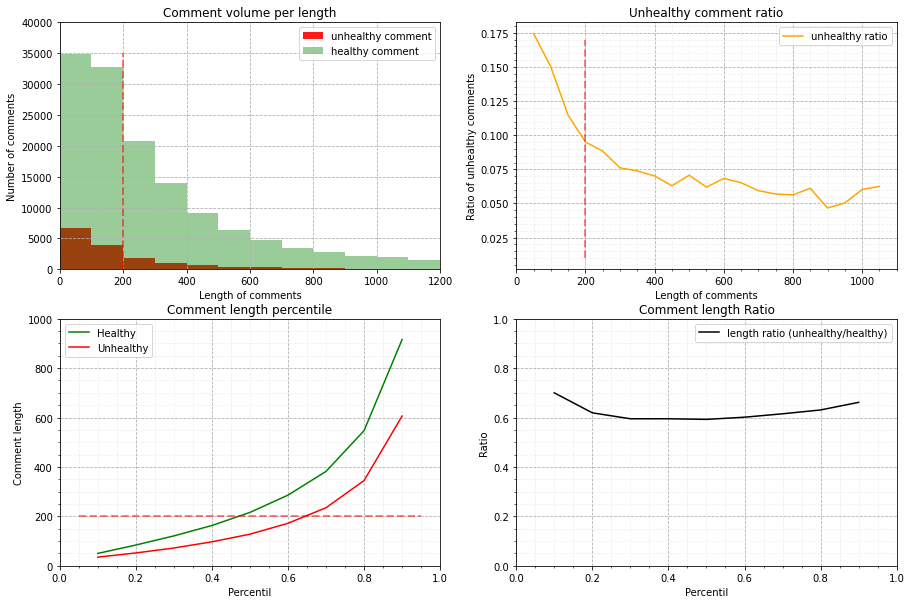

In [ ]:
run_analysis()


### Action

> * Focus on the comments shorter than **200**.
> * **A/B test** for comment length requirement - A for minimum comment length and B for none.<BR>

Comment length requirement may discourage providing comments. However those who have the intention to contribute would still proceed, hence improving the quality of the comments.

### Further Considerations

* Analysi per the label type - What differentiates the comment classified as **(toxic and insult)** from **(toxic not insult)**, etc.


## Utility (Vocabulary)

In [ ]:
clean = WordAnalysis(" ".join(train[train['unhealthy'] == 0]['comment_text'].values))
dirty = WordAnalysis(" ".join(train[train['unhealthy'] > 0]['comment_text'].values))

def show_alert_words():
    words_only_in_dirty = set(dirty.vocabulary) - set(clean.vocabulary)
    _words = []
    for word in words_only_in_dirty:
        _words = _words + ([word] * dirty.count(word))
    filthy = WordAnalysis(" ".join(_words))
    image_filthy_words = generate_wordcloud_image(" ".join(_words))
    del _words

    n = 10
    print("--------------------------------------------------------------------------------")
    print(f"Top {n} most used alert words in unhealthy comments")
    print("--------------------------------------------------------------------------------")
    for word, ratio in filthy.top(n):
        print(f"{word:20s} {ratio:0.5f}")

    plt.figure(figsize=(12, 10))
    plt.title("Words only in unhealthy comments", fontsize=30)
    plt.axis("off")
    plt.imshow(image_filthy_words, interpolation = 'bilinear')
    del image_filthy_words

def show_divine_words():
    words_only_in_clean = set(clean.vocabulary) - set(dirty.vocabulary)
    _words = []
    for word in words_only_in_clean:
        _words = _words + ([word] * clean.count(word))
    divine = WordAnalysis(" ".join(_words))
    image_divine_words = generate_wordcloud_image(" ".join(_words))
    del _words

    n = 10
    print("--------------------------------------------------------------------------------")
    print(f"Top {n} most used divine words in healthy comments")
    print("--------------------------------------------------------------------------------")
    for word, ratio in divine.top(n):
        print(f"{word:20s} {ratio:0.5f}")

    plt.figure(figsize=(12, 10))
    plt.title("Words only in healthy comments", fontsize=35)
    plt.axis("off")
    plt.imshow(image_divine_words, interpolation = 'bilinear')
    del image_divine_words

def show_more_frequent_words_than_normal():
    _ratio = 10.0
    words_common = set.intersection(set(dirty.vocabulary), set(clean.vocabulary))
    _words = [
        word for word in words_common 
        if dirty.probability(word) / clean.probability(word) > _ratio
    ]
    _image_more_frequent_words = generate_wordcloud_image(" ".join(_words))

    plt.figure(figsize=(12, 10))
    plt.title("Words more frequent in unhealthy comments", fontsize=30)
    plt.axis("off")
    plt.imshow(_image_more_frequent_words, interpolation = 'bilinear')
    del _words
    del _image_more_frequent_words

x = 0.0
for word in clean.vocabulary:
    x += dirty.probability(word)
print(f"[{(1.0 - x) * 100:2.2f}] % of the words in unhealthy comments are only used in there.")

x = 0.0
for word in dirty.vocabulary:
    x += clean.probability(word)
print(f"[{(1.0 - x) * 100:2.2f}] % of the words in healthy comments are only used in there.")

[6.57] % of the words in unhealthy comments are only used in there.
[9.54] % of the words in healthy comments are only used in there.


## Vocabulary

### Objective

**Co-relation** between the certain **vocabulary** to the **healthiness** of a comment. Healthiness is a binary classification either a comment is healthy or unhealthy where "unhealthy" comments are those labeled as toxic, insult, etc.

### Findings

> * The **Foul words** would directly identify unhealthy comments. Those **6.57 %** of the unhealthy words never occurrs in healthy comments.
> * The **Alert words** would help identify unhealthy comments. Those words occurres **10** times more in unhealthy comments than healthy ones.
> * The **divine words** would directly identify healthy comments. Those **9.54 %** of the healthy words never occurrs in unhealthy comments.


### Foul Words

--------------------------------------------------------------------------------
Top 10 most used alert words in unhealthy comments
--------------------------------------------------------------------------------
fucksex              0.02087
yourselfgo           0.02077
cocksucker           0.01826
buttsecks            0.01665
mothjer              0.01635
notwat               0.01572
offfuck              0.01204
proassadhanibalyou   0.01154
niggas               0.01154
bitchesfuck          0.01114


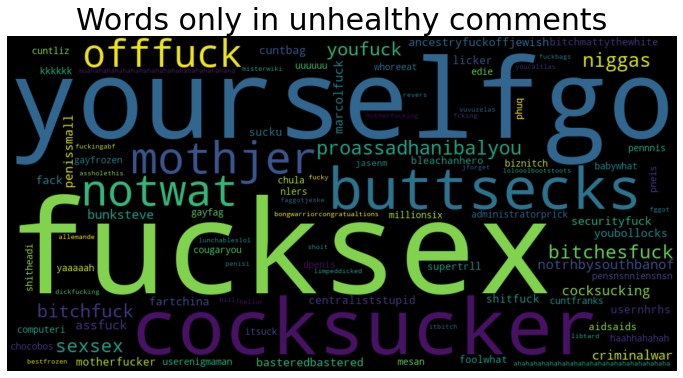

In [ ]:
show_alert_words()

### Alert Words

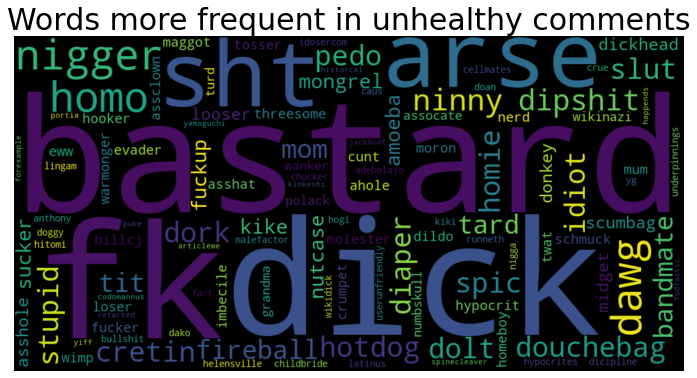

In [ ]:
show_more_frequent_words_than_normal()

### Divine Words

Skipped due to the resource consumption restriction.

--------------------------------------------------------------------------------
Top 10 most used divine words in healthy comments
--------------------------------------------------------------------------------
tacos                0.00162
wikipediahi          0.00152
verticalaligntop     0.00129
stylewidth           0.00119
backgroundcolorffffa 0.00098
philippineslong      0.00089
borderpx             0.00085
newsletter           0.00085
cellpadding          0.00079
nikko                0.00076


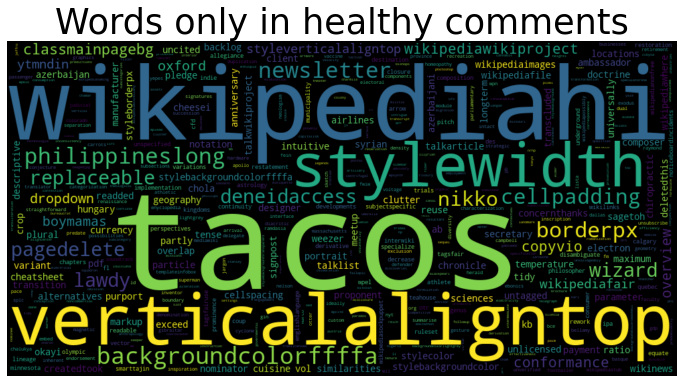

In [ ]:
# Takes too long
show_divine_words()


### Actions

> * Filter those comments including the **foul words** 
> * Raise cases to investigate into comments including the **alert words**

### Further Considerations

* Capital letters - 
Offensive comments can include more capital letters e.g. NONSENSE!

* Exclamation marks - 
Offensive comments can include more exclamation usages e.g. NONSENSE!!!!

* Imperative forms - The offensive comments can be more directive.

* Emoji - Healthy comments can include more emoji e.g. ðŸ¤— 

ML would be a good option to find such patterns from the text comments.



## Vocabulary Size

### Objective
Correlation from the variety of the vocabulary to the healthiness of a comment. 

### Findings
> * Significantly **less vocabulary** is used in the unhealthy comments.

### Actions

TBD. Need further analysis.

Vocaburary size healthy[198802] unhealthy[32997]


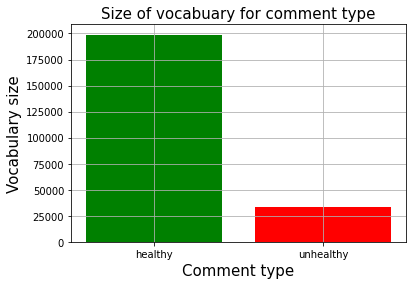

In [ ]:
print(f"Vocaburary size healthy[{clean.size()}] unhealthy[{dirty.size()}]")
plt.bar(["healthy", "unhealthy"], [clean.size(), dirty.size()], color = ['green','red'])
plt.xlabel('Comment type', fontsize=15)
plt.ylabel('Vocabulary size', fontsize=15)
plt.title('Size of vocabuary for comment type', fontsize=15)    
plt.grid()   

In [ ]:
del clean, dirty
gc.collect()

41391